# Handwritten digits recognition

The loader for the MNIST image data was taken from Nielsen's online book,

http://neuralnetworksanddeeplearning.com/chap1.html

See specifically the following link, for downloading the MNIST image data (we only need the mnist.pkl.gz package inside the 'data' subdirectory; store it inside the present directory of the notebook):
https://github.com/mnielsen/neural-networks-and-deep-learning/archive/master.zip


In [1]:
# Import keras library. Also import some of the layers, so we do not need to
# write things like "layers.Dense", but can just write "Dense" instead
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GaussianDropout
import tensorflow.keras.optimizers as optimizers

# Import the numpy library for matrix manipulations etc.

#from numpy import *
import numpy as np
from numpy import array, zeros, exp, random, dot, shape, transpose, reshape, meshgrid, linspace, sqrt

# Set up the graphics by importing the matplotlib plotting library
import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# Set up a random number generator with a fixed seed, so that
# running this whole notebook repeatedly should always give
# the same result (useful for debugging)
rng = random.RandomState(23455)

import time

2023-03-24 17:22:05.739748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
"""
mnist_loader
~~~~~~~~~~~~

taken from Nielsen's online book:
http://neuralnetworksanddeeplearning.com/chap1.html


A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('./neural-networks-and-deep-learning-master/data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='bytes')
    print("shape of the training images:{:}".format(training_data[0].shape))
    print("shape of the training labels:{:}".format(training_data[1].shape))
    
    print("shape of the validation images:{:}".format(validation_data[0].shape))
    print("shape of the validation labels:{:}".format(validation_data[1].shape))
    
    print("shape of the test images:{:}".format(test_data[0].shape))
    print("shape of the test labels:{:}".format(test_data[1].shape))  
    f.close()
    return (training_data, validation_data, test_data)



def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    
    global training_inputs, training_results
    global validation_inputs, validation_results
    global test_inputs, test_results
    global num_samples, numpixels, num_test_samples
    
    def manipulate_data(data):
        """manipulate the original MINIST data for training purpose (adapt with the NN)"""
        num_samples_tmp = len(data[0])
        data_inputs = np.zeros([num_samples_tmp, numpixels])
        data_results = np.zeros([num_samples_tmp, 10])
        for j in range(num_samples_tmp):
            # fatten the 2d images into a 1d array
            data_inputs[j,: ] = np.reshape(data[0][j], (numpixels))
            # one hot encode the labels
            data_results[j,: ] = vectorized_result(data[1][j])
      
        return data_inputs, data_results
    
    tr_d, va_d, te_d = load_data()
    
    # number of training samples
    num_samples = len(tr_d[0])
    # number of testing samples
    num_test_samples = len(te_d[0])
    
    # training data
    training_inputs, training_results = manipulate_data(tr_d)
    # validation data
    validation_inputs, validation_results = manipulate_data(va_d)
    # test data
    test_inputs, test_results = manipulate_data(te_d)


def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = zeros((10))
    e[j] = 1.0
    return e

In [3]:
# initialize the network
def init_net():
    global net, numpixels
    net = Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    net.add(Dense(30, input_shape=(numpixels,), activation='relu'))
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])
    net.summary()

In [4]:
# initialize the network
def init_net_large():
    global net, numpixels
    net = Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    net.add(Dense(100, input_shape=(numpixels,), activation='relu'))
    net.add(GaussianDropout(0.1))
    net.add(Dense(50, activation='relu'))
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])
    net.summary()

In [5]:
def test_on(start,stop,dontprint=False):
    global test_inputs, test_results
    global net, predictions_probs, predictions, true_labels
    
    predictions_probs=net.predict_on_batch(test_inputs[start:stop,:])
    predictions=np.argmax(predictions_probs,axis=1)
    if dontprint==False:
        print("Predictions: ", predictions)
    true_labels=np.argmax(test_results[start:stop,:], axis=1)
    if dontprint==False:
        print("True labels: ", true_labels)

In [6]:
def display_image(which):
    global test_inputs
    
    plt.imshow(reshape(test_inputs[which,:],[28,28]),interpolation='nearest', cmap='binary')
    plt.show()

In [7]:
def display_image_array(which):
    global test_inputs
    
    numcolumns=8
    BigImage=zeros([28*numcolumns,28*numcolumns])
    for j in range(len(which)):
        x=(j%numcolumns)*28
        y=int(j/numcolumns)*28
        BigImage[x:x+28,y:y+28]=reshape(test_inputs[which[j],:],[28,28])
    plt.imshow(BigImage,interpolation='nearest', cmap='binary')
    plt.show()

In [8]:
def display_mistakes(maxnum):
    global test_inputs, rest_results, num_test_samples
    global true_labels, predictions, predictions_probs
    
    test_on(0,num_test_samples,dontprint=True)
    which=np.where(true_labels!=predictions)[0]
    for j in which:
        if j<maxnum:
            display_image(j)
            print("True ", true_labels[j], " - Predicted ", predictions[j], " with prob. ", predictions_probs[j,predictions[j]])
        

## Load and process the MINIST DATA

In [9]:
# load data 
numpixels=784
load_data_wrapper() # load all the MNIST images

shape of the training images:(50000, 784)
shape of the training labels:(50000,)
shape of the validation images:(10000, 784)
shape of the validation labels:(10000,)
shape of the test images:(10000, 784)
shape of the test labels:(10000,)


## Principle Component Analysis (PCA)

In [10]:
shape(training_inputs)


(50000, 784)

In [11]:
# subtract average 
psi=training_inputs-np.sum(training_inputs,axis=0)/num_samples
# construct "Density matrix"
rho = np.dot(np.transpose(psi), psi)
print("shape of the 'density matrix':{:}".format(rho.shape))
# diagonalize the "Dansity matrix"
vals, vecs = np.linalg.eig(rho)
# normalize the eigenvalues
vals /= sum(vals)
print("first 10 elements of the eigen values:\n{:}".format(vals[:10]))
print("last 10 elements of the eigen values:\n{:}".format(vals[-10:]))
print("shape of the eigenvector:{:}".format(vecs.shape))


shape of the 'density matrix':(784, 784)
first 10 elements of the eigen values:
[0.09744386 0.07059849 0.06216131 0.05379486 0.04858055 0.04319612
 0.03277574 0.02886384 0.02768835 0.02365928]
last 10 elements of the eigen values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape of the eigenvector:(784, 784)


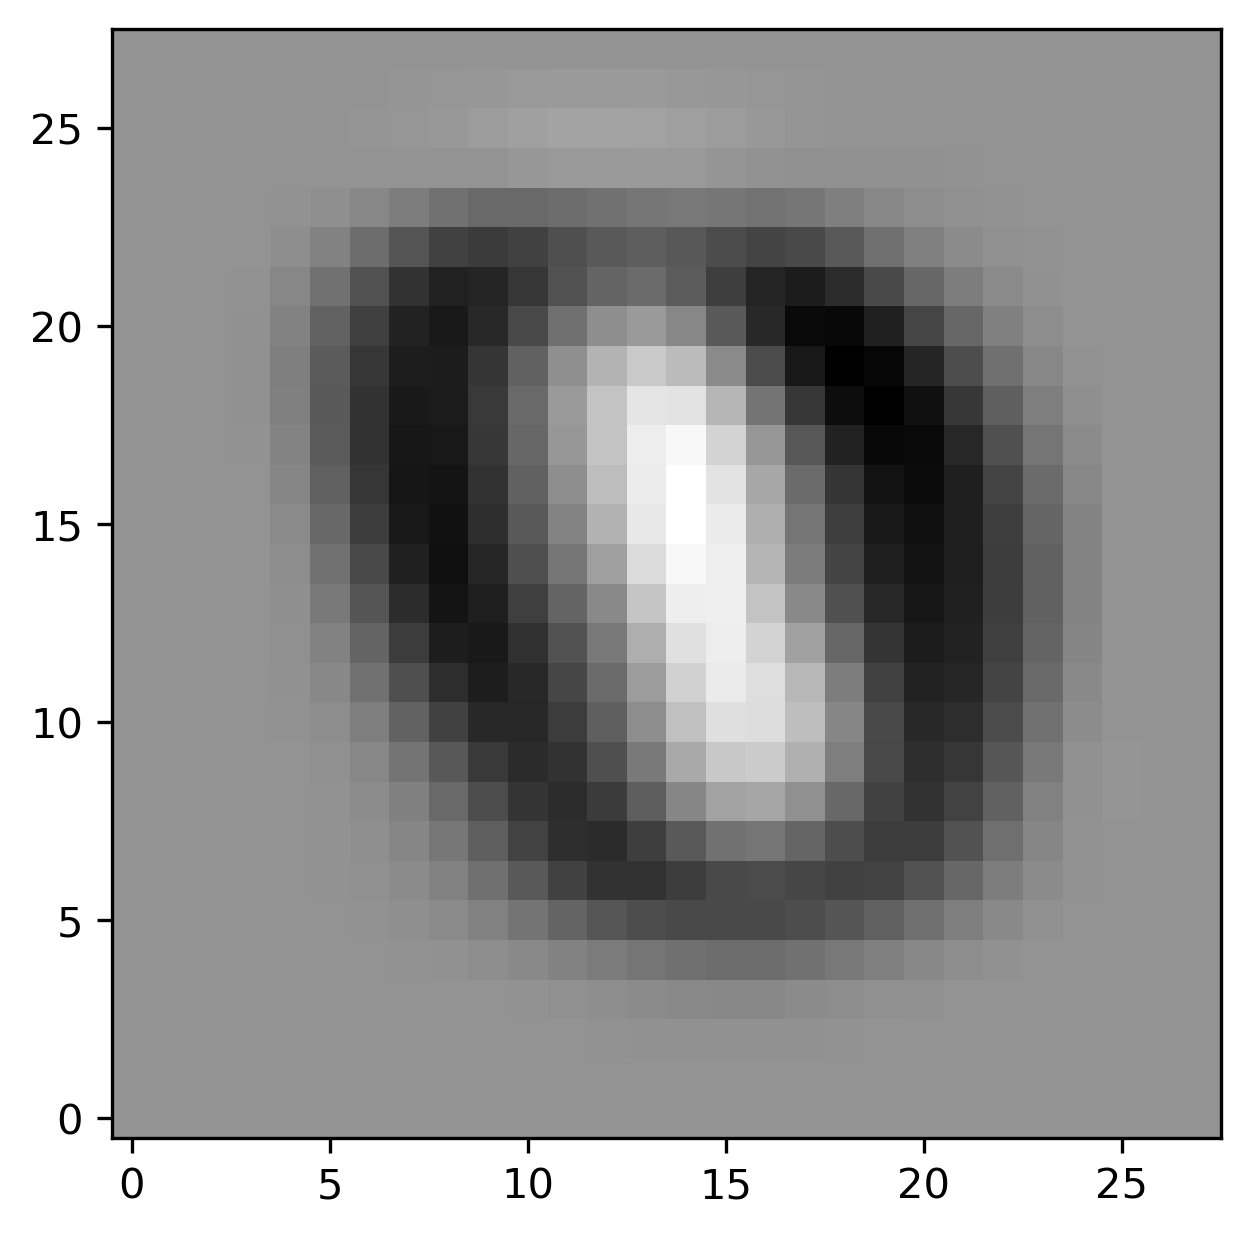

In [12]:
# plot the "Eigenvectors"
plt.imshow(np.reshape(vecs[:,0], [28, 28]), origin='lower', cmap='binary', interpolation='nearest')


This PCA illustration, the "PCA" in quantum mechanics is equavalent to a linear one layer autoencoder. 
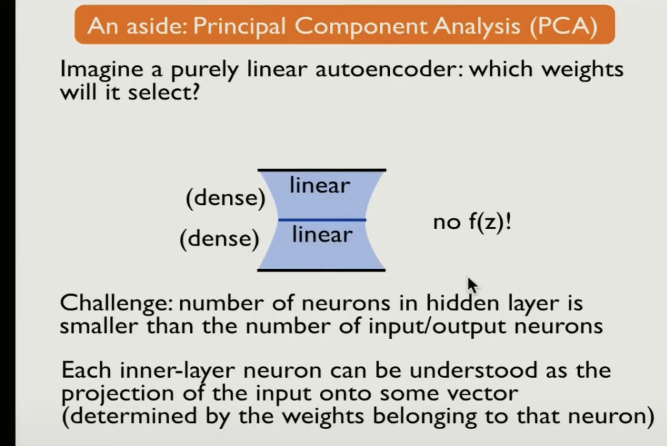

# Build a linear one hidden (dense) autoencoder

In [13]:
Net = Sequential()
# input layer
Net.add(Dense(10, input_shape=(numpixels,), activation=None))
# hidden layer
Net.add(Dense(numpixels, activation=None))
# output layer
Net.compile(loss='mean_squared_error',
              optimizer='adam')
Net.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 784)               8624      
                                                                 
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


2023-03-24 17:22:09.392858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# construct density matrix
history=Net.fit(rho,vecs,batch_size=numpixels,
                epochs=30,validation_split=0.1)


Epoch 1/30
1/1 [==============================] - 0s 400ms/step - loss: 19202.0293 - val_loss: 322.6633
Epoch 2/30
1/1 [==============================] - 0s 16ms/step - loss: 14752.8584 - val_loss: 273.5199
Epoch 3/30
1/1 [==============================] - 0s 18ms/step - loss: 11439.2637 - val_loss: 234.4828
Epoch 4/30
1/1 [==============================] - 0s 19ms/step - loss: 8993.8174 - val_loss: 202.8582
Epoch 5/30
1/1 [==============================] - 0s 19ms/step - loss: 7193.2603 - val_loss: 176.8381
Epoch 6/30
1/1 [==============================] - 0s 19ms/step - loss: 5867.8887 - val_loss: 155.3951
Epoch 7/30
1/1 [==============================] - 0s 19ms/step - loss: 4888.7651 - val_loss: 138.1531
Epoch 8/30
1/1 [==============================] - 0s 19ms/step - loss: 4156.9331 - val_loss: 125.0332
Epoch 9/30
1/1 [==============================] - 0s 20ms/step - loss: 3599.1123 - val_loss: 115.8287
Epoch 10/30
1/1 [==============================] - 0s 18ms/step - loss: 3163.0

In [15]:
output = Net.predict_on_batch(rho)
output.shape




(784, 784)

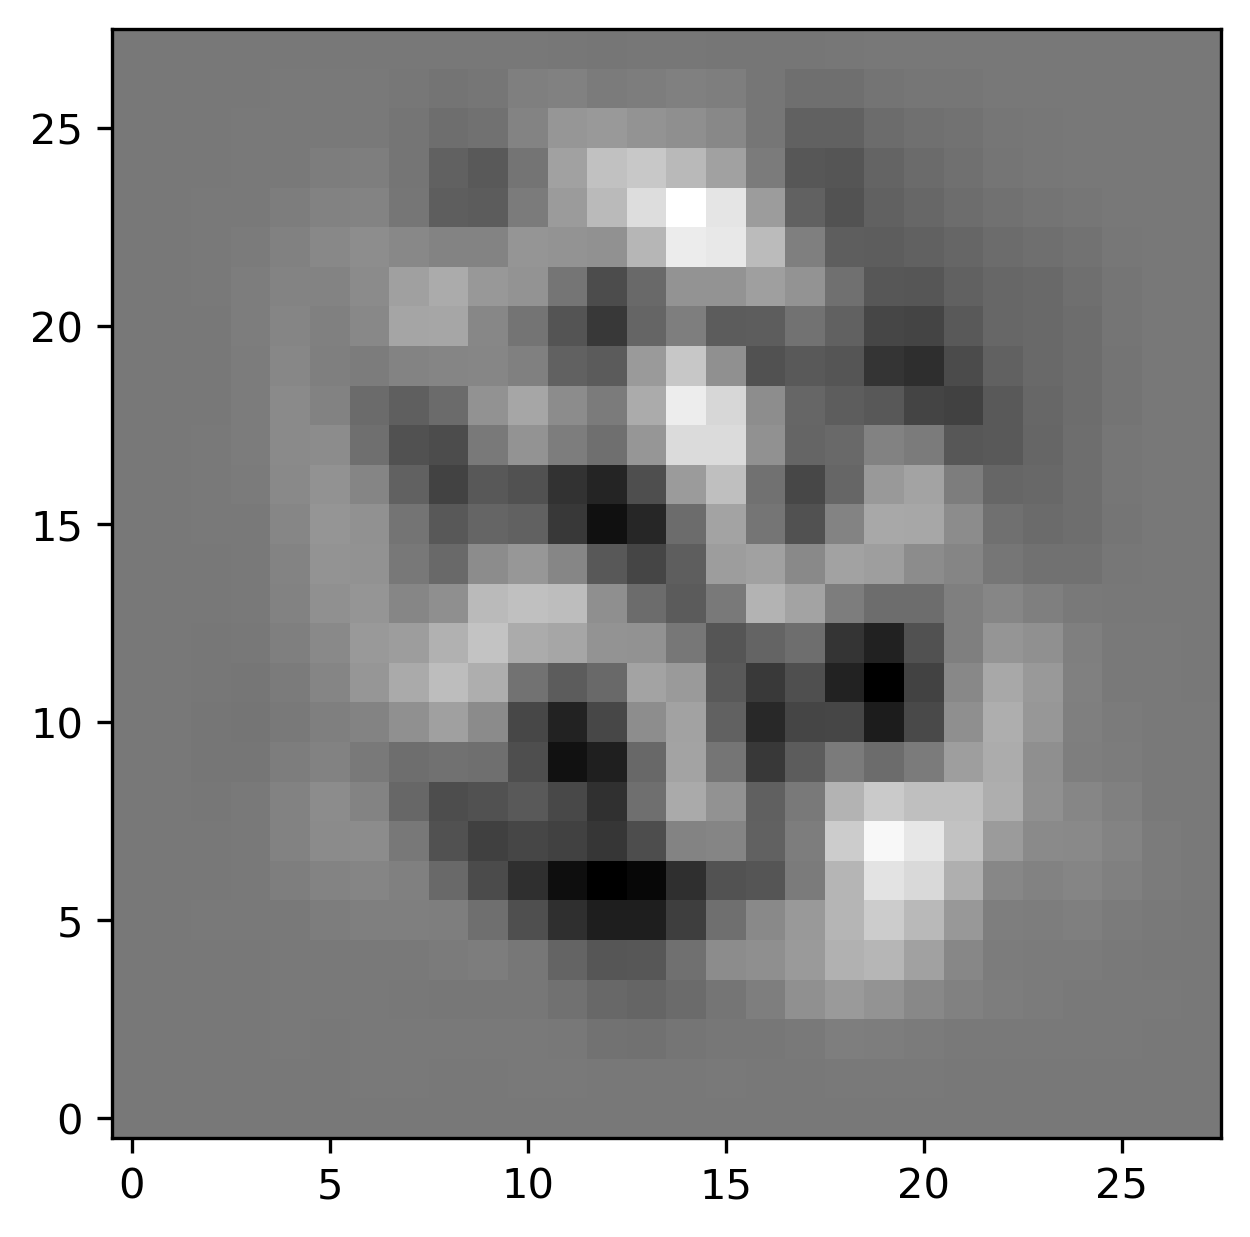

In [18]:
plt.imshow(np.reshape(output[:,0], [28, 28]), origin='lower', cmap='binary', interpolation='nearest')
